In [40]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="p2hFSvlF0e2xt5nFlAsJlzwHu",
    project_name="recommender-system",
    workspace="celelwazi",
)

ImportError: You must import Comet before these modules: sklearn

## import libraries

In [1]:
import numpy as np 
import pandas as pd  

#visualization
import scipy as sp  
from scipy import sparse 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib.request

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#recommender systems
from surprise import *
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

#saving model
import pickle

## load datasets

In [2]:
train_df = pd.read_csv("/kaggle/input/edsamovies/train.csv")
test_df = pd.read_csv("/kaggle/input/edsamovies/test.csv")
genome_scores = pd.read_csv("/kaggle/input/edsamovies/genome_scores.csv")
genome_tags = pd.read_csv("/kaggle/input/edsamovies/genome_tags.csv")
imdb_data = pd.read_csv("/kaggle/input/edsamovies/imdb_data.csv")
links_df = pd.read_csv("/kaggle/input/edsamovies/links.csv")
movies_df = pd.read_csv("/kaggle/input/edsamovies/movies.csv")
tags_df = pd.read_csv("/kaggle/input/edsamovies/tags.csv")
sample_submission = pd.read_csv("/kaggle/input/edsamovies/sample_submission.csv")

In [3]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
test_df.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [5]:
print(train_df.isnull().sum())
print(train_df.shape)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
(10000038, 4)


In [6]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies_df.loc[movies_df["title"].duplicated() == True]
duplicates = movies_df.duplicated(["title"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 98


In [8]:
# check movies with missing genres
movies_df.loc[movies_df["genres"] == "(no genres listed)"].head()

,movieId,title,genres
15881,83773,Away with Words (San tiao ren) (1999),(no genres listed)
16060,84768,Glitterbug (1994),(no genres listed)
16351,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed)
16491,87061,Trails (Veredas) (1978),(no genres listed)
17404,91246,Milky Way (Tejút) (2007),(no genres listed)


In [9]:
movies_df[movies_df["genres"] == "(no genres listed)"].count()

movieId    5062
title      5062
genres     5062
dtype: int64

## data cleaning

In [10]:
df = train_df.copy(deep=True)

In [11]:
#removing timestamp as it serves no purpose in determining user rating
df = df.iloc[:, :-1]

In [12]:
#checking duplicated movies
duplicate = movies_df.loc[movies_df.duplicated('title')]

In [13]:
duplicate

,movieId,title,genres
9065,26982,Men with Guns (1997),Drama
12909,64997,War of the Worlds (2005),Action|Sci-Fi
12984,65665,Hamlet (2000),Drama
13177,67459,Chaos (2005),Crime|Drama|Horror
16120,85070,Blackout (2007),Drama
...,...,...,...
61521,206117,The Lonely Island Presents: The Unauthorized B...,Comedy
61525,206125,Lost & Found (2018),Comedy|Drama
61697,206674,Camino (2016),Comedy
61800,206925,The Plague (2006),Documentary


In [14]:
# Random check differences between first & second occurence of title in movies
movies_df.loc[movies_df["title"] == "Men with Guns (1997)"]

,movieId,title,genres
1710,1788,Men with Guns (1997),Action|Drama
9065,26982,Men with Guns (1997),Drama


In [15]:
movies_df.loc[movies_df["title"] == "War of the Worlds (2005)"]

,movieId,title,genres
10055,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
12909,64997,War of the Worlds (2005),Action|Sci-Fi


In [16]:
# Dropping duplicated movie titles.
# Dropping the second occurences of duplicated movies
# as the first occurences have more than 1 genre
movies_df = movies_df.drop(
    movies_df.loc[movies_df["title"].duplicated(keep='first') == True].index)


In [17]:
#checking if duplicates where removed
movies_df.loc[movies_df["title"].duplicated(keep='first') == True].count()

movieId    0
title      0
genres     0
dtype: int64

In [18]:
# remove the separator between genres
movies_df["genres"] = movies_df["genres"].str.replace("|", " ", regex=False)
# Check movies_df
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


## merging datasets

In [19]:
# Merge dataframes on common column
df_movie_info = pd.merge(train_df,movies_df,on = "movieId")

In [20]:
# merge movies_df and imdb_df on a common column ,i.e "movieId"
movies_merge = pd.merge(
    movies_df, imdb_data[['runtime', "movieId", 'budget', ]], on="movieId")
movies_merge['year'] = movies_merge['title'].str.split().str[-1]
movies_merge["year"] = movies_merge["year"].str.replace("(", "", regex=False)
movies_merge["year"] = movies_merge["year"].str.replace(")", "", regex=False)
movies_merge = movies_merge[~movies_merge['year'].str.contains(
    '[A-z]', na=False)]
movies_merge = movies_merge[~movies_merge['year'].str.contains(
    '[a-z]', na=False)]
movies_merge["year"] = movies_merge["year"].astype(float)
movies_merge1 = movies_merge.copy()
movies_merge = movies_merge.dropna()
movies_merge = movies_merge[movies_merge['budget'].str.startswith('$')]
movies_merge["budget"] = movies_merge["budget"].str.replace(
    "$", "", regex=False)
movies_merge["budget"] = movies_merge["budget"].str.replace(
    ",", "", regex=False)
movies_merge["budget"] = movies_merge["budget"].astype(float)
movies_merge.head()

,movieId,title,genres,runtime,budget,year
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,81.0,30000000.0,1995.0
1,2,Jumanji (1995),Adventure Children Fantasy,104.0,65000000.0,1995.0
2,3,Grumpier Old Men (1995),Comedy Romance,101.0,25000000.0,1995.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,124.0,16000000.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,106.0,30000000.0,1995.0


## EXPLORATORY DATA  ANALYSIS

In [21]:
print("Summary of df:")
print("Number of unique movies = " + str(len(np.unique(df["movieId"]))))
print("Number of unique users = " + str(len(np.unique(df["userId"]))))
print("Total number of movie ratings = " + str(df.shape[0]))

Summary of df:
Number of unique movies = 48213
Number of unique users = 162541
Total number of movie ratings = 10000038


### ratings analysis

In [22]:
# 10 users with the most ratings
no_of_rated_movies_per_user = df_movie_info.copy(deep=True)
no_of_rated_movies_per_user[
    'user_ratings'] = no_of_rated_movies_per_user.groupby(
        by="userId")["rating"].count().sort_values(ascending=False)
no_of_rated_movies_per_user.groupby(
    by="userId")["rating"].count().sort_values(ascending=False)[:10]

userId
72315     12934
80974      3679
137293     3586
33844      3207
20055      3050
109731     2670
49403      2667
92046      2578
110971     2287
30879      2283
Name: rating, dtype: int64

In [23]:
# Highest number of ratings by single user in database
# Lowest number of ratings by single user in database
print("Summary of user ratings: ")
print("Highest number of ratings by single user in database = " + str(
    max(no_of_rated_movies_per_user.groupby(
        by="userId")["rating"].count().sort_values(ascending=False))))

print("Lowest number of ratings by single user in database = " + str(
    min(no_of_rated_movies_per_user.groupby(
        by="userId")["rating"].count().sort_values(ascending=False))))


Summary of user ratings: 
Highest number of ratings by single user in database = 12934
Lowest number of ratings by single user in database = 1


In [24]:
#most rated movies
ratings_per_movie = df_movie_info.groupby(
    by="title")["rating"].mean().sort_values(ascending=True)
ratings_per_movie.tail()

## does not show true reflection, elaboration to be completed

title
Detective Conan: The Raven Chaser (2009)    5.0
Rockabilly Zombie Weekend (2013)            5.0
Sweaty Betty (2015)                         5.0
Robert Williams Mr. Bitchin' (2013)         5.0
Day the Universe Changed, The (1985)        5.0
Name: rating, dtype: float64

In [25]:
# movies with the most ratings
df_movie_info.groupby('title')['rating'].count().sort_values(
    ascending=False)[:10]

title
Shawshank Redemption, The (1994)             32831
Forrest Gump (1994)                          32383
Pulp Fiction (1994)                          31697
Silence of the Lambs, The (1991)             29444
Matrix, The (1999)                           29014
Star Wars: Episode IV - A New Hope (1977)    27560
Jurassic Park (1993)                         25518
Schindler's List (1993)                      24004
Braveheart (1995)                            23722
Fight Club (1999)                            23536
Name: rating, dtype: int64

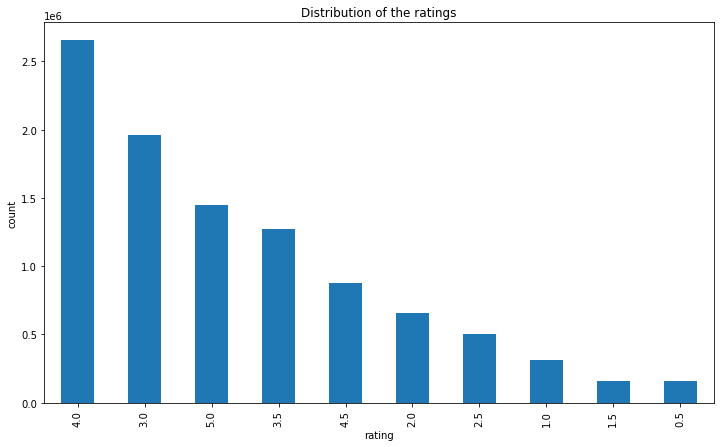

In [26]:
plt.figure(figsize=(12, 7))
df_movie_info['rating'].value_counts().plot(kind='bar',
                                            title='Distribution of the ratings')
plt.ylabel('count')
plt.xlabel('rating')
experiment.log_figure(figure=plt, figure_name='Ratings per Movie')
plt.show()

In [26]:
# creating new dataframe where we can see movie title
# along with the average rating and number of ratings for the movie
ratings_mean_count = pd.DataFrame(
    df_movie_info.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(
    df_movie_info.groupby('title')['rating'].count())
ratings_mean_count.head()


,rating,rating_counts
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


<AxesSubplot:title={'center':'Average ratings'}, xlabel='rating', ylabel='number of ratings'>

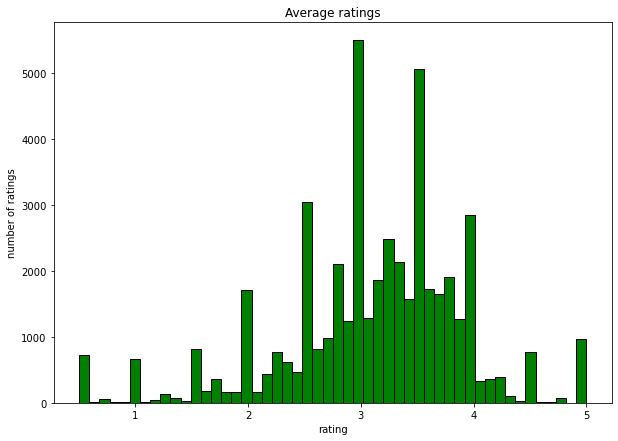

In [27]:
# histogram to visualize average ratings
plt.figure(figsize=(10, 7))
plt.xlabel("rating")
plt.ylabel("number of ratings")
plt.title("Average ratings")
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50, grid=False, color='green')


### genres analysis

In [28]:
# Create new dataframe to see the genres
genres = movies_df['genres'].str.replace("|", " ", regex=False)
genres = genres.str.replace("(no genres listed)", "Not_listed", regex=False)
genres_string = ' '.join(genres)
all_genres = genres_string.split()


# function to get unique genres ,to avoid repetation in dataframe
def unique_genres(genre_list):
    """The function inputs the genres of the movies and outputs all the unique genres 
    """
    # insert the list to the set
    list_set = set(genre_list)
    # convert the set to the list
    unique_list = (list(genre_list))
    return unique_list

all_genres = unique_genres(all_genres)
print("The number are " + str(
    len(set(all_genres))) + " unique movie genres in the dataframe")


The number are 20 unique movie genres in the dataframe


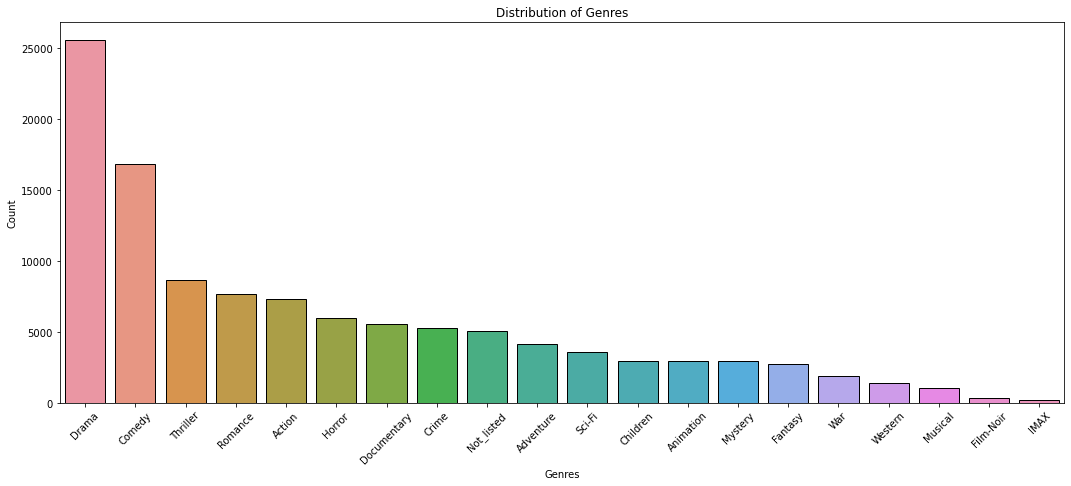

In [30]:
# visualising genre distribution 
total_genresdf = pd.DataFrame(all_genres)
total_genresdf = total_genresdf[0].value_counts()
total_genresdf = pd.DataFrame(total_genresdf).reset_index()
total_genresdf['Genres'] = total_genresdf['index']
total_genresdf['Count'] = total_genresdf[0]
plt.figure(figsize=(18, 7))
plt.title('Distribution of Genres')
sns.barplot(x='Genres', y='Count', data=total_genresdf)


# Rotate the genres for better visualizations
plt.xticks(rotation=45)
experiment.log_figure(figure=plt, figure_name='Distribution of Genres')
plt.show()


NameError: name 'experiment' is not defined

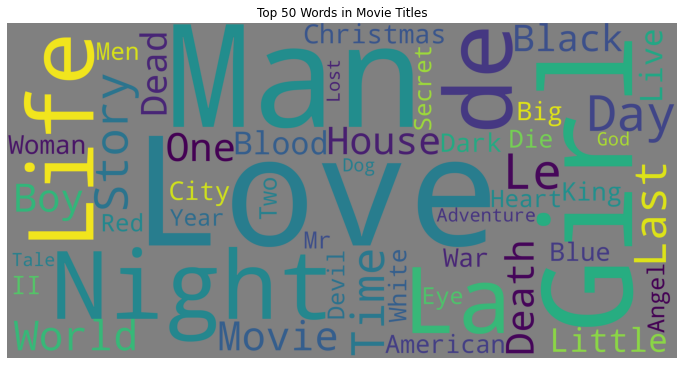

In [29]:
title_corpus = ' '.join(movies_df['title'])
title_wordcloud = WordCloud(
    stopwords=STOPWORDS, background_color='grey',
    height=2000, width=4000, max_words=50).generate(title_corpus)
plt.figure(figsize=(12, 8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title("Top 50 Words in Movie Titles")
experiment.log_figure(figure=plt, figure_name='Top 50 Words in Movie Titles')
plt.show()


## Modeling

In [30]:
# Instantiate the reader object
reader = Reader()
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

#### SVD

In [31]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8339  0.8337  0.8334  0.8341  0.8343  0.8339  0.0003  
MAE (testset)     0.6333  0.6331  0.6328  0.6330  0.6336  0.6332  0.0003  
Fit time          1662.55 891.68  1054.19 934.33  837.88  1076.13 301.75  
Test time         1363.45 856.04  1033.70 1080.43 1116.75 1090.08 163.39  


{'test_rmse': array([0.8338904 , 0.83369244, 0.83337442, 0.83406807, 0.83426424]),
 'test_mae': array([0.6333096 , 0.63307742, 0.63278492, 0.63303017, 0.63364124]),
 'fit_time': (1662.548062324524,
  891.6833958625793,
  1054.1933166980743,
  934.3264186382294,
  837.8835034370422),
 'test_time': (1363.4495995044708,
  856.0416238307953,
  1033.70463180542,
  1080.4333803653717,
  1116.7535281181335)}

#### NMF

In [32]:
cross_validate(NMF(), data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([0.88960132, 0.88777117, 0.8891923 ]),
 'fit_time': (519.1627595424652, 2457.712089776993, 534.4567873477936),
 'test_time': (1974.7937276363373, 1713.54083943367, 1954.3871638774872)}

#### Baseline

In [33]:
bsl_options = {'method': 'als', 'n_epochs': 5,'reg_u': 12,'reg_i': 5}
cross_validate(BaselineOnly(bsl_options=bsl_options), data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.86759052, 0.86806361, 0.8673521 ]),
 'fit_time': (56.03705430030823, 110.2891936302185, 546.3713808059692),
 'test_time': (2471.413335800171, 2111.5585720539093, 2347.070893764496)}

In [34]:
algorithms = ['SVD', 'BaselineOnly', 'NMF']
rmse_scores = [0.83372139, 0.86809963, 0.8886319]
pd.DataFrame(rmse_scores, algorithms, columns=['RMSE'])

,RMSE
SVD,0.833721
BaselineOnly,0.868100
NMF,0.888632


#### Saving best performing algorithm

In [35]:
# Define the algorithm
algorithm_svd_tuned = SVD(lr_all=0.009, n_factors=20)

# Build the trainset
trainset = data.build_full_trainset()

# Fit the model
algorithm_svd_tuned.fit(trainset)

#### Predictions

In [36]:

def get_predictions(algorithm):
    """
    The functions makes predictions of ratings
    to match them with the user_movie ids.

    Parameters
    -----------
    model : fitted model
    Returns
    -------
    Pandas Dataframe :
        dataframe with user_movie ids and ratings
    """
    # Create a new list to add predictions.
    # Iterate over the test_df, select user and movie.
    # Predict ratings using the algo.predict() method.
    # Append the predictions to the p list.
    X = test_df[['userId', 'movieId']]
    p = []
    for k in range(len(test_df)):
        user = X.iloc[k][0]
        movie = X.iloc[k][1]
        predicted = algorithm.predict(user, movie).est
        p.append(predicted)

    predictions = [round(num, 3) for num in p]

    # Create dataframe for the ratings.
    # Create dataframe for the user_movie ids.
    # Concatenate the two dataframes.
    rate = np.array(predictions)
    rating = pd.DataFrame(rate, columns=['rating'])

    Idd = np.array([str(x)+"_"+str(y) for x, y in test_df[[
        'userId', 'movieId']].values]).reshape(-1, 1)
    Id = pd.DataFrame(Idd, columns=['Id'])

    data_df = pd.concat([Id, rating], axis=1)

    return data_df


In [37]:
predicted = get_predictions(algorithm_svd_tuned)
predicted.head()

,Id,rating
0,1_2011,3.160
1,1_4144,4.126
2,1_5767,3.776
3,1_6711,3.864
4,1_7318,2.127


#### Kaggle submission

In [38]:
predicted.to_csv("svd_sub.csv", index=False)